# Probabilistic Roadmap


In this notebook we will expand on previous random sampling exercises by creating a graph from the points and running A*.

We follow next steps:

1. Load the obstacle map data
2. Sample nodes (use KDTrees here)
3. Connect nodes (use KDTrees here)
4. Visualize graph
5. Define heuristic
6. Define search method
7. Execute and visualize

In [1]:
# The latest version of networkx is needed
# This sometimes fails for unknown reasons. In such a case, 
# just "reset and clear output" from the "Kernel" menu above 
# and try again!
import sys
!{sys.executable} -m pip install -I networkx==2.1
import pkg_resources
pkg_resources.require("networkx==2.1")
import networkx as nx

print('\nNetworkX version is {}'.format(nx.__version__)) # It should be 2.1

  Using cached networkx-2.1-py2.py3-none-any.whl
  Using cached decorator-5.1.1-py3-none-any.whl (9.1 kB)

NetworkX version is 2.1


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, LineString
from sklearn.neighbors import KDTree
import time
from queue import PriorityQueue

from sampling import Sampler   # Custom Sampler classs using KDtree for collision check
from grid import create_grid

%matplotlib inline

plt.rcParams['figure.figsize'] = 13, 13

### Step 1 - Load Data obstacle map data

In [3]:
# Obstacle data
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print('Data shape:', data.shape)
print('\n',data)

Data shape: (3845, 6)

 [[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


### Step 2 - Sample Point using KD tree

In [4]:
# Initialize sampler object from Sample class with 'data'
sampler = Sampler(data)      # Sampler class sets maximum z = 20 for sampling points

# Sampling random nodes and removing those conflicting with obstacles using KDtree
nodes_to_sample = 400
nodes = sampler.sample(nodes_to_sample)
print('{} of {} nodes do not collide with any obstacle'.format(len(nodes),nodes_to_sample))

270 of 400 nodes do not collide with any obstacle


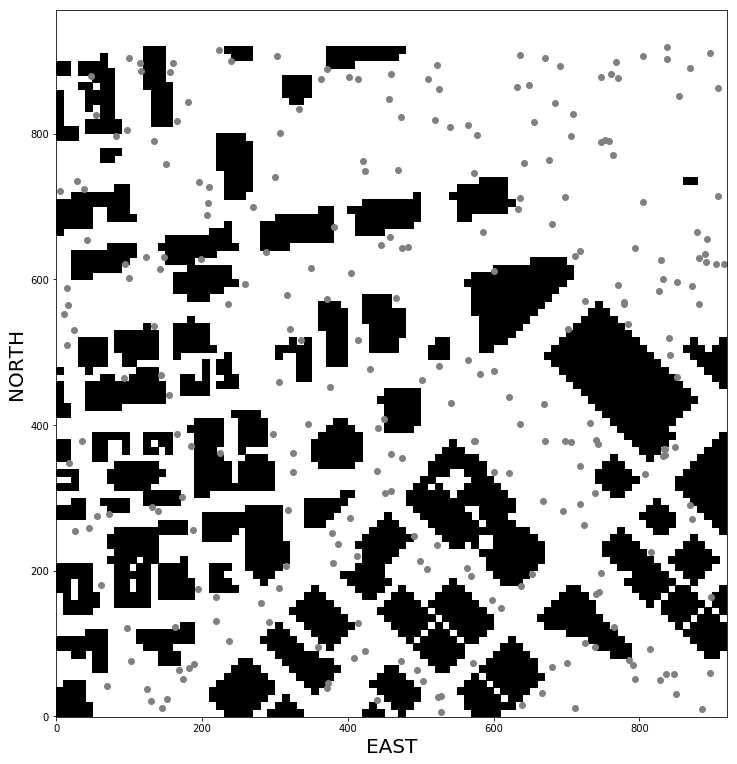

In [7]:
# Create a grid map of the world at 21 m above ground level (1m over sampled points)
grid = create_grid(data, 21, 0)

fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.floor(np.min(data[:, 0] - data[:, 3]))
emin = np.floor(np.min(data[:, 1] - data[:, 4]))

# Draw all nodes connected or not in blue
for node in nodes:
    plt.scatter(node[1] - emin, node[0] - nmin, c='grey')

plt.xlabel('EAST', fontsize=20)
plt.ylabel('NORTH', fontsize=20)

plt.show()

### Step 3 - Connect Nodes

Now we have to connect the nodes. There are many ways to do these. The only restriction being no edge connecting two nodes may pass through an obstacle.

NOTE: You can use `LineString()` from the `shapely` library to create a line. Additionally, `shapely` geometry objects have a method `.crosses` which return `True` if the geometries cross paths, for instance your `LineString()` with an obstacle `Polygon()`!

In [8]:
# Create polygons from sampler object
polygons = sampler._polygons

def can_connect(n1, n2):
    ''' This function checks whether a connection between two points 
        it is possible or not. It is not possible if the line that
        links the points crosses a polygon
        '''
    line = LineString([n1, n2])   # Creation of lineString object
    for poly in polygons:        
        if poly.crosses(line) and poly.height >= min(n1[2], n2[2]):   # NO tengo claro la necesidad del height check
            return False
    return True
    
def create_graph(nodes, k):
    '''This function create a graph made up of feasible
       connections between the input nodes
       k: number of nearest nodes to search with KDTree
    '''
    g = nx.Graph()       # Graph creation
    tree = KDTree(nodes) # Tree creation
    
    for node in nodes:   # for each node, identify the indexes of the k nearest nodes
        idxs = tree.query([node], k, return_distance=False)[0]
        
        for idx in idxs: # for each nearest node
            node_b = nodes[idx]
            if node_b == node:     # Skip node_b if identical
                continue
            if can_connect(node, node_b):
                g.add_edge(node, node_b, weight = 1)
                
    return g


In [10]:
# 3D graph creation;
t0 = time.time()
g = create_graph(nodes, k=10)      # Note the impact of k value (nearest nodes in the KDTree)

print('Graph took {0} seconds to build'.format(time.time()-t0))
print("Number of edges:", len(g.edges))

Graph took 23.769179105758667 seconds to build
Number of edges: 754


### Step 4 - Visualize 3D Graph

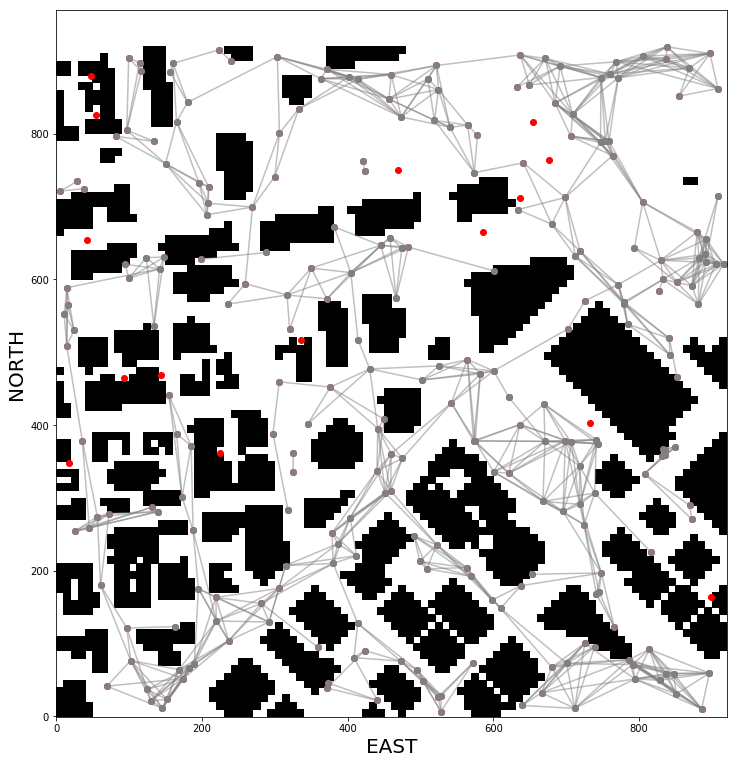

In [11]:
# Create a grid map of the world at 21 m above ground level (1m over sampled points)
grid = create_grid(data, 21, 0)

fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.floor(np.min(data[:, 0] - data[:, 3]))
emin = np.floor(np.min(data[:, 1] - data[:, 4]))

# If you have a graph called "g" these plots should work
# Draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'grey' , alpha=0.5)

# Draw all nodes in red
for n1 in nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    
# Draw connected nodes in blue
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='grey') 

plt.xlabel('EAST', fontsize=20)
plt.ylabel('NORTH', fontsize=20)

plt.show()

### Step 5 - Define Heuristic

In [12]:
def Euclidean_d(node1, node2):
    dx = node2[0] - node1[0]
    dy = node2[1] - node1[1] 
    return ((dx**2 + dy**2)**0.5)

### Step 6 - Search method: A*

In [13]:
def a_star(graph, heuristic, start, goal):
    """Modified A* to work with NetworkX graphs."""
    
    # TODO: complete
    return []

# A* IMPLEMENTATION for graphs
def a_star(graph, heuristic, start, goal):
    ''' A* implementation for dealing with NetworkX graphs
    '''
    path = []
    path_cost = 0
    queue = PriorityQueue()   # Priority queue for prioritizing expanding cells with lower cost
    queue.put((0, start))     # (cost, cell); cost value is use for priority
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        # Get and remove the first element from the queue
        item = queue.get()
        current_node = item[1]
        
        # Assignation of current cost
        if current_node == start:
            current_cost = 0.0
        else:              
            current_cost = branch[current_node][0]
        
        # If the current cell corresponds to the goal state, stop the search
        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for next_node in graph[current_node]:               # For every node connected to the current node
                cost = graph.edges[current_node, next_node]['weight']   # extract cost(=weitgh value) to get there
                
                # Branch cost evaluation (action.cost + g)
                branch_cost = current_cost + cost
                
                # Heuristics distance evaluation
                queue_cost = branch_cost + heuristic(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    branch[next_node] = (branch_cost, current_node)
                    queue.put((queue_cost, next_node))     
                    
    if found:
        # retrace steps
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
    else:
        print('**********************')
        print('Failed to find a path!')
        print('**********************') 
    return path[::-1], path_cost

In [14]:
# Definition of start location
start = list(g.nodes)[0]
print('Start location',start)

# Random definition of goal location poi
k = np.random.randint(len(g.nodes))
goal = list(g.nodes)[k]
print('Goal location:',goal)

Start location (424.97542409679517, -145.33767274860065, 5.843093636536947)
Goal location: (62.61728071857834, -409.45996860628907, 14.904699167819697)


In [15]:
# Run A* on the graph
path, cost = a_star(g, Euclidean_d, start, goal)
print('Path length: {}'.format(len(path)))

# Path segments
path_pairs = zip(path[:-1], path[1:])

Found a path.
Path length: 18


### Step 7 - Visualize Path from start to goal

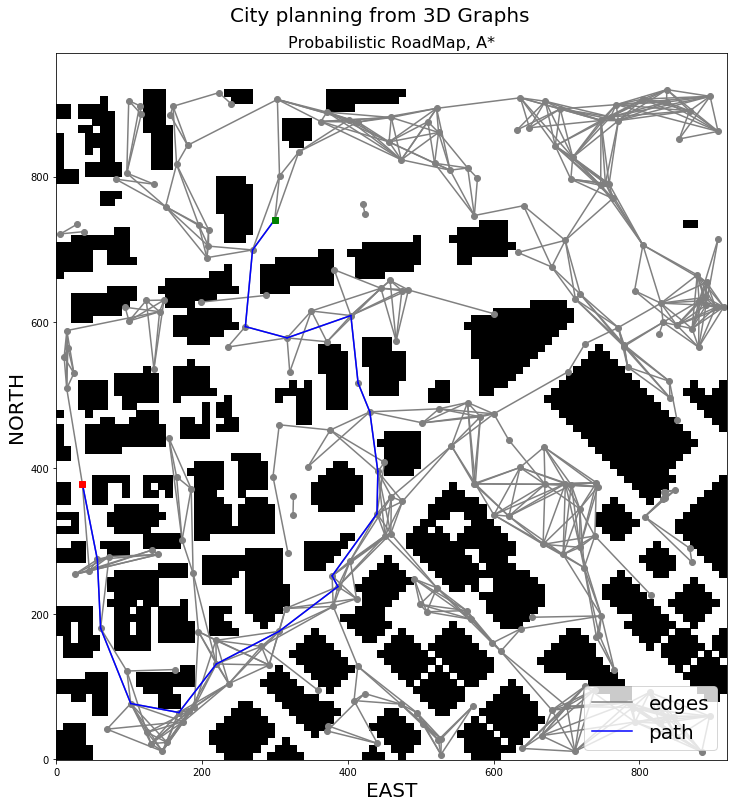

In [17]:
# Plotting
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.floor(np.min(data[:, 0] - data[:, 3]))
emin = np.floor(np.min(data[:, 1] - data[:, 4]))

# Draw nodes
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='grey')
    
# draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'grey', label = 'edges')
    
# Add code to visualize the path
path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'blue', label = 'path')

plt.plot(start[1]- emin, start[0]- nmin, 's', color = 'green') # Closest-to-graph start location
plt.plot(goal[1]- emin, goal[0]- nmin, 's', color = 'red')    # Closest-to-graph goal location

plt.xlabel('EAST', fontsize=20)
plt.ylabel('NORTH', fontsize=20)
plt.suptitle('City planning from 3D Graphs', fontsize=20, x=0.5, y=0.93)
plt.title('Probabilistic RoadMap, A*', fontsize=16, x=0.5, y=1.0)

plt.legend(loc='lower right', fontsize=20)
plt.show()
